# Lets use custom English to Telugu Data Set for Machine Translation Task

### Import Section

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os
import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Bidirectional,Attention,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tqdm import tqdm 
tqdm.pandas()
from tensorflow.keras.utils import plot_model
import tensorflow as tf

## Lets Load the Dataset

In [2]:
!gdown 1mPHb2r7XGW8UiaFGw0Ew_2O8ljHLgEV9

Downloading...
From: https://drive.google.com/uc?id=1mPHb2r7XGW8UiaFGw0Ew_2O8ljHLgEV9
To: /content/english_telugu_data.txt
100% 20.3M/20.3M [00:00<00:00, 135MB/s]


In [3]:
# read phrases from english_telugu_data.txt file
english_sentances = []
telugu_sentances = []
with open('/content/english_telugu_data.txt', mode='rt', encoding='utf-8') as fp:
    for line in fp.readlines():
        eng_tel = line.split("++++$++++")
        english_sentances.append(eng_tel[0])
        telugu_sentances.append(eng_tel[1])

In [4]:
# Lets See Some Sample Sentences
for i in np.random.choice(range(len(english_sentances)),size = 5):
  print('*'*30 + ' Sentence '+ str(i)+ ' '+'*'*30)
  print()
  print(str(english_sentances[i])  +  '  ---->  ' + str(telugu_sentances[i]))

****************************** Sentence 122176 ******************************

Tom forced me to go.  ---->  టామ్ నన్ను బలవంతంగా వెళ్ళాడు.

****************************** Sentence 11587 ******************************

Tom wasn't the one who broke the window.  ---->  కిటికీ పగలగొట్టినది టామ్ కాదు.

****************************** Sentence 150773 ******************************

It was horrendous.  ---->  ఇది భయంకరమైనది.

****************************** Sentence 77219 ******************************

It turns out that I have a brother.  ---->  నాకు సోదరుడు ఉన్నారని తేలింది.

****************************** Sentence 20449 ******************************

It's a kind of cat.  ---->  ఇది ఒక రకమైన పిల్లి.



In [5]:
data = pd.DataFrame({"english_sentances":english_sentances,"telugu_sentances":telugu_sentances})

In [6]:
data.head()

,english_sentances,telugu_sentances
0,His legs are long.,అతని కాళ్ళు పొడవుగా ఉన్నాయి.\n
1,Who taught Tom how to speak French?,టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు?\n
2,I swim in the sea every day.,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.\n
3,Tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
4,Smoke filled the room.,పొగ గదిని నింపింది.\n


In [7]:
data.shape

(155798, 2)

## Lets Do some Text Preprocessing

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# clean english sentances
def clean_eng(text):
    # Lowercase all characters
    text = text.lower()
    # map contractions
    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove extra spaces
    text= text.strip()
    return text

In [10]:
# clean telugu sentances
def clean_tel(text):
    # Lowercase all characters
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()
    text = 'START_ '+ text + ' _END'
    return text

In [11]:
# clean text
preprocessed_data = data.copy()
preprocessed_data["english_sentances"] = preprocessed_data["english_sentances"].progress_apply(lambda x: clean_eng(x))
preprocessed_data["telugu_sentances"] = preprocessed_data["telugu_sentances"].progress_apply(lambda x: clean_tel(x))

100%|██████████| 155798/155798 [00:01<00:00, 80339.85it/s]


In [12]:
preprocessed_data.head()

,english_sentances,telugu_sentances
0,his legs are long,START_ అతని కాళ్ళు పొడవుగా ఉన్నాయి _END
1,who taught tom how to speak french,START_ టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు ...
2,i swim in the sea every day,START_ నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను _END
3,tom popped into the supermarket on his way hom...,START_ టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళ...
4,smoke filled the room,START_ పొగ గదిని నింపింది _END


In [13]:
# Vocabulary of English
all_eng_words=set()
for eng in preprocessed_data.english_sentances:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Telugu 
all_telugu_words=set()
for tel in preprocessed_data.telugu_sentances:
    for word in tel.split():
        if word not in all_telugu_words:
            all_telugu_words.add(word)

In [14]:
# Max Length of source sequence(English)
lenght_list=[]
for l in preprocessed_data.english_sentances:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

101

In [15]:
# Max Length of target sequence
lenght_list=[]
for l in preprocessed_data.telugu_sentances:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar



30

In [16]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_telugu_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_telugu_words)
num_encoder_tokens, num_decoder_tokens

(13909, 38724)

In [17]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens



38725

In [18]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [19]:
reverse_input_token_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_token_index = dict((i, word) for word, i in target_token_index.items())

In [20]:
preprocessed_data = shuffle(preprocessed_data, random_state=45)
preprocessed_data.head(10)

,english_sentances,telugu_sentances
101532,tom said mary was hungry,START_ టామ్ మేరీ ఆకలితో అన్నాడు _END
131407,tell your mother about the trip,START_ ట్రిప్ గురించి మీ తల్లికి చెప్పండి _END
95344,we will feed the kids first,START_ మేము మొదట పిల్లలకు ఆహారం ఇస్తాము _END
72530,we have something in common,START_ మాకు ఉమ్మడిగా ఏదో ఉంది _END
136134,you underestimate me,START_ మీరు నన్ను తక్కువ అంచనా వేస్తారు _END
137789,i always stay at home on sundays,START_ నేను ఎల్లప్పుడూ ఆదివారాలు ఇంట్లో ఉంటాను...
60602,this is a government project,START_ ఇది ప్రభుత్వ ప్రాజెక్టు _END
77267,the weather is unusually cold,START_ వాతావరణం అసాధారణంగా చల్లగా ఉంటుంది _END
114714,i will do what i can for you,START_ నేను మీ కోసం నేను చేయగలిగినదాన్ని చేస్త...
93157,i do not like bugs,START_ నాకు దోషాలు నచ్చవు _END


## Lets Split the data into train and test split


In [21]:
# Train - Test Split
X, y = preprocessed_data.english_sentances, preprocessed_data.telugu_sentances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((140218,), (15580,))

In [22]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                #print('*'*30)
                #print(encoder_input_data)
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Encoder Decoder Architecture

<center><img src = "https://miro.medium.com/max/640/0*bM9oRET5AGEdpaRv.webp"></center>


<center><img src = "https://miro.medium.com/max/720/1*1TWWOY6Zu5UrGMu8ccf-iw.webp"></center>


In [23]:
Embedding_vector_dimensions = 100
lstm_units = 50

In [24]:
tf.keras.backend.clear_session()

## Encoder block


In [25]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, Embedding_vector_dimensions, mask_zero = True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(lstm_units, return_state=True))
encoder_outputs, forward_h,forward_c,backward_h,backward_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

## Decoder Block

In [26]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, Embedding_vector_dimensions, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(Embedding_vector_dimensions, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [27]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1390900     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 100),        60400       ['embedding[0][0]']              
                                 (None, 50),                                                  

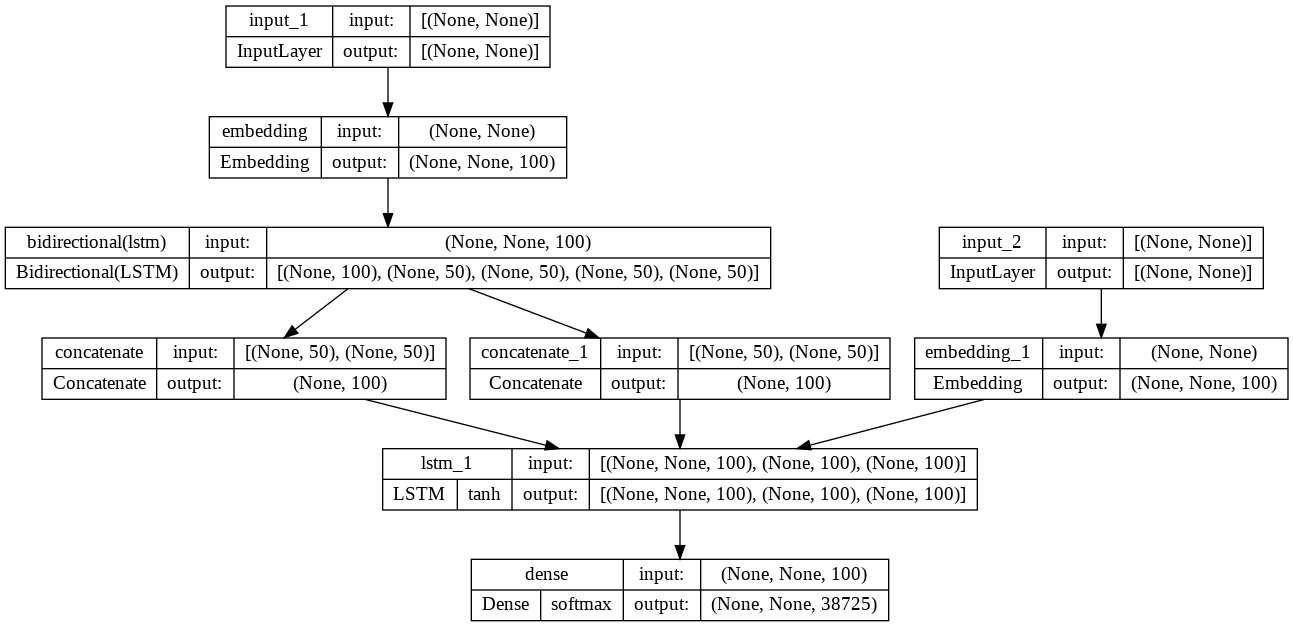

In [29]:
plot_model(model,show_shapes=True,show_layer_activations = True)

In [30]:
batch_size = 128
epochs = 10
train_samples_steps = len(X_train) // batch_size
val_samples_steps = len(X_test) // batch_size

In [31]:
# generate train and test datra
train_gen = generate_batch(X_train, y_train, batch_size = batch_size)
test_gen = generate_batch(X_test, y_test, batch_size = batch_size)

In [32]:
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2,patience = 3, min_lr = 0.000001)

In [33]:
filepath="model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [39]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose=1)

In [35]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
%reload_ext tensorboard

In [36]:
# train the model
model.fit(train_gen,
                    steps_per_epoch = train_samples_steps,
                    epochs=epochs,
                    validation_data = test_gen,
                    validation_steps = val_samples_steps,callbacks = [reduce_alpha,checkpoint,earlystop,tensorboard_callback])



Epoch 1/10
1095/1095 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.2567
Epoch 1: val_loss improved from inf to 0.94706, saving model to model_save/weights-01-0.9471.hdf5
1095/1095 [==============================] - 551s 489ms/step - loss: 1.1004 - accuracy: 0.2567 - val_loss: 0.9471 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 2/10
1095/1095 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.3807
Epoch 2: val_loss improved from 0.94706 to 0.77646, saving model to model_save/weights-02-0.7765.hdf5
1095/1095 [==============================] - 548s 500ms/step - loss: 0.8351 - accuracy: 0.3807 - val_loss: 0.7765 - val_accuracy: 0.4207 - lr: 0.0010
Epoch 3/10
1095/1095 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.4629
Epoch 3: val_loss improved from 0.77646 to 0.66991, saving model to model_save/weights-03-0.6699.hdf5
1095/1095 [==============================] - 528s 482ms/step - loss: 0.6793 - accuracy: 0.4629 - val_los

In [40]:
# train the model
model.fit(train_gen,
                    steps_per_epoch = train_samples_steps,
                    epochs=5,
                    validation_data = test_gen,
                    validation_steps = val_samples_steps,callbacks = [reduce_alpha,checkpoint,earlystop,tensorboard_callback])

Epoch 1/5
1095/1095 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.8538
Epoch 1: val_loss improved from 0.40703 to 0.40670, saving model to model_save/weights-01-0.4067.hdf5
1095/1095 [==============================] - 519s 474ms/step - loss: 0.1243 - accuracy: 0.8538 - val_loss: 0.4067 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/5
1095/1095 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.8641
Epoch 2: val_loss did not improve from 0.40670
1095/1095 [==============================] - 484s 442ms/step - loss: 0.1150 - accuracy: 0.8641 - val_loss: 0.4074 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 3/5
1095/1095 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.8751
Epoch 3: val_loss did not improve from 0.40670
1095/1095 [==============================] - 523s 478ms/step - loss: 0.1049 - accuracy: 0.8751 - val_loss: 0.4075 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 4/5
1095/1095 [==============================] - ETA: 0s 

In [42]:
model.load_weights('/content/model_save/weights-01-0.4067.hdf5')

### Inference Setup

In [43]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(Embedding_vector_dimensions,))
decoder_state_input_c = Input(shape=(Embedding_vector_dimensions,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)



### Decode sample sequeces

In [48]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Evaluation on Train Dataset

In [49]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
for k in range(20):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input English sentence:', X_test[k:k+1].values[0])
    print('Actual Telugu Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Telugu Translation:', decoded_sentence[:-4])
    print("\n")



1/1 [==============================] - 0s 15ms/step
Input English sentence: you have not told anyone have you
Actual Telugu Translation:  మీరు ఎవరికీ చెప్పలేదు ఉందా 
Predicted Telugu Translation:  మీకు ఎవరికీ చెప్పలేదు ఉందా 


1/1 [==============================] - 0s 19ms/step
Input English sentence: had you been drinking
Actual Telugu Translation:  మీరు తాగుతున్నారా 
Predicted Telugu Translation:  మీరు తాగడం ఇష్టమా 


1/1 [==============================] - 0s 15ms/step
Input English sentence: how did you know i was hungry
Actual Telugu Translation:  నేను ఆకలితో ఉన్నానని మీకు ఎలా తెలుసు 
Predicted Telugu Translation:  నేను ఆకలితో ఉన్నానని మీకు తెలుసా 


1/1 [==============================] - 0s 21ms/step
Input English sentence: so what do you mean
Actual Telugu Translation:  కాబట్టి మీ ఉద్దేశ్యం ఏమిటి 
Predicted Telugu Translation:  మీ ఉద్దేశ్యం ఏమిటి 


1/1 [==============================] - 0s 15ms/step
Input English sentence: do not you have to work
Actual Telugu Translation:  మీరు